<a href="https://colab.research.google.com/github/alexanderjohnny/dsc-mod-4-project-v2-1-online-ds-pt-100719/blob/master/ALEX_BEAT_v2_1mod4project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COLAB PREP STUFF

Colab zip file working code used to speed up image processing is obtained from this blog: https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd ~
%cd ..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/root
/


In [2]:
import os,glob

print(os.path.abspath(os.curdir))

source_folder = r'content/drive/My Drive/Datasets/'

file = glob.glob(source_folder+'xray.zip',recursive=True)[0]
file

/


'content/drive/My Drive/Datasets/xray.zip'

In [3]:
zip_path = file

!cp "{zip_path}" .

!unzip -q xray.zip
!rm xray.zip

In [4]:
import os,glob
print(os.path.abspath(os.curdir))
os.listdir()


/


['home',
 'tmp',
 'dev',
 'srv',
 'boot',
 'sys',
 'run',
 'lib64',
 'media',
 'bin',
 'usr',
 'mnt',
 'var',
 'sbin',
 'lib',
 'proc',
 'etc',
 'opt',
 'root',
 'xray',
 'content',
 '.dockerenv',
 'tools',
 'datalab',
 'swift',
 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl',
 'tensorflow-1.15.2',
 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl',
 'lib32']

# Mod 4 Project - Image Classification

* Student name: Alex Beat
* Student pace: part time
* Scheduled project review date/time: 06/24/20 @12pm pacific
* Instructor name: James Irving
* Blog post URL: NA

# Intro

* Problem: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.
* Audience: Medical business, imaging labs. 
* Business Questions: How can a successful model help save medical professionals time, money and promote better accuracy in patient diagnosis. 

## Content
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

(Content info and dataset provided by Paul Mooney on Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia?)

# Step 1: Load the Data

In [5]:
!pip install -U fsds_100719
from fsds_100719.imports import *


fsds_1007219  v0.7.22 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [6]:
np.random.seed(111)


In [7]:

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [8]:
# Necessary libraries and classes

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import models
from keras import layers
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

# Step 2: Data Preprocessing

DEFINING FOLDER STRUCTURE FOR USE WITH .FLOW

In [9]:
#  Set up directory paths from gdrive
train_dir_normal = 'xray/train/NORMAL'
train_dir_pneum = 'xray/train/PNEUMONIA'
test_dir_normal = 'xray/test/NORMAL'
test_dir_pneum = 'xray/test/PNEUMONIA'
val_dir_normal = 'xray/val/NORMAL'
val_dir_pneum = 'xray/val/PNEUMONIA'
all_dir_paths = [train_dir_normal, train_dir_pneum, test_dir_normal,
                 test_dir_pneum, val_dir_normal, val_dir_pneum]

In [10]:
# use loop to get number of samples from all folders
for dataset in all_dir_paths: 
  print(str(dataset), len(os.listdir(dataset))) 

xray/train/NORMAL 1342
xray/train/PNEUMONIA 3419
xray/test/NORMAL 234
xray/test/PNEUMONIA 390
xray/val/NORMAL 0
xray/val/PNEUMONIA 0


In [11]:
import glob,os


In [12]:
# use glob to get filenames of all images in each folder
train_files_normal = glob.glob(train_dir_normal+'/*.jpeg')
train_files_pneum = glob.glob(train_dir_pneum+'/*.jpeg')
all_train_files = [*train_files_normal,*train_files_pneum]

test_files_normal = glob.glob(test_dir_normal+'/*.jpeg')
test_files_pneum = glob.glob(test_dir_pneum+'/*.jpeg')
all_test_files = [*test_files_normal,*test_files_pneum]

# hashed out bc I don't have val files currently
# val_files_normal = glob.glob(val_dir_normal+'/*.jpeg'
# val_files_pneum = glob.glob(train_dir_pneum+'/*.jpeg'
# all_val_files = [*val_files_normal,*val_files_pneum]

all_filename_vars = [train_files_normal, train_files_pneum,
                        test_files_normal, test_files_pneum]
                        # , val_files_normal, val_files_pneum]

## Functions

In [13]:
# functions used from https://colab.research.google.com/drive/1fwXPY3IDHxNiv7YgOpt3p5BvUaO4VruB?usp=sharing
from PIL import Image
from keras.preprocessing import image
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm

def read_img(img_path,target_size=(64, 64)):
  """This function reads in the image using the image path filenames created by glob. 
  Then it turns the image into an arrary for use with modeling. Specify target pixel 
  size using target_size=(n,n). Default is 64,64 pixels."""
  
  img = image.load_img(img_path, target_size=target_size)
  img = image.img_to_array(img)
  
  return img

def load_train_test_val_images(training_filenames_normal, training_filenames_pneum,
                        test_filenames_normal, test_filenames_pneum,
                        # val_filenames_normal, val_filenames_pneum,
                        img_size=(64,64)):
    """Reads in training, test and val filenames, uses read_img() to change to 
    change img to numpy array, then produces X and y data splits, in addition to
    creating proper binary labels for modeling. The validation set is intended 
    to be used after training and testing model.

    ylabels are encoded as 0=normal, 1=pneumonia
    Returns:  X_train, X_test, X_val, y_train, y_test, y_val"""
    
    display('[i] LOADING IMAGES')


 # create empty lists to contain the image filenames and another to contain
 # the classification ylabel for each image.
    train_img = []
    train_label = []

# reads in and classifies training normal label
    for img_path in tqdm(training_filenames_normal):
        train_img.append(read_img(img_path,target_size=img_size))
        train_label.append(0)

# reads in and classifies training penumonia label
    for img_path in tqdm(training_filenames_pneum):
        train_img.append(read_img(img_path,target_size=img_size))
        train_label.append(1)


 # create empty lists to contain the image filenames and another to contain
 # the classification ylabel for each image.
    test_img = []
    test_label = []

# reads in and classifies test normal label
    for img_path in tqdm(test_filenames_normal):
        test_img.append(read_img(img_path,target_size=img_size))
        test_label.append(0)

# reads in and classifies test penumonia label
    for img_path in tqdm(test_filenames_pneum):
        test_img.append(read_img(img_path,target_size=img_size))
        test_label.append(1)

    
    # val_img = []
    # val_label = []

    # for img_path in tqdm(val_filenames_normal):
    #     val_img.append(read_img(img_path,target_size=img_size))
    #     val_label.append(0)

    # for img_path in tqdm(val_filenames_pneum):
    #     train_img.append(read_img(img_path,target_size=img_size))
    #     train_label.append(1)


# create your X_train and y_train variables for use in modeling
    X_train = np.array(train_img, np.float32)
    y_train = np.array(train_label)

    X_test = np.array(test_img, np.float32)
    y_test = np.array(test_label)

    # X_val = np.array(val_img, np.float32)
    # y_val = np.array(val_label)

# Prints the length of each split for use in batching and knowledge of data. 
    print('\n[i] Length of Splits:')
    # print(f"X_train={len(X_train)}, X_test={len(X_test)}, X_val={len(X_val)}")
    print(f"X_train={len(X_train)}, X_test={len(X_test)}")

    # return X_train, X_test, X_val, y_train, y_test,y_val 
    return X_train, X_test, y_train, y_test


# def train_test_val_datagens(X_train,X_test,X_val,y_train,y_test,y_val,
def train_test_val_datagens(X_train, X_test, y_train, y_test,
                            BATCH_SIZE = 32, train_datagen_kws= dict(
                                shear_range = 0.2, 
                                zoom_range = 0.2)):
                              
    """Takes in your training and test data and creates ImageDataGenerators 
    for train,test,val data. This will normalize your image array data.
    Returns: training_set,test_set,val_set"""

    ## Create training and test data image generators. 
    # This will normalize the image pixel data.
    from keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(rescale = 1./255,**train_datagen_kws)

    test_datagen = ImageDataGenerator(rescale = 1./255)

    # val_datagen = ImageDataGenerator(rescale = 1./255)

    training_set = train_datagen.flow(X_train,y=y_train,batch_size=BATCH_SIZE)
    test_set = test_datagen.flow(X_test,y=y_test,batch_size=BATCH_SIZE)
    # val_set = val_datagen.flow(X_val,y=y_val,batch_size=BATCH_SIZE)

    return training_set, test_set, # val_set



def get_shapes_dict(training_set,verbose=True):
    shapes = ["Batchsize", "img_width","img_height","img_dim"]
    SHAPES = dict(zip(shapes, training_set[0][0].shape))
    if verbose:
        print('SHAPES DICT:')
        print(SHAPES)
        print(training_set[0][0].shape)
        print('\n[i] Labels for batch (0=normal,1=pneumonia)')
        print(training_set[0][1])
    return SHAPES

In [14]:
## USING FUNCTIONS TO LOAD IN IMAGES 
# X_train,X_test,X_val,y_train,y_test,y_val = load_train_test_val(*all_filename_vars,
#                                                 img_size=(64,64)
X_train,X_test,y_train,y_test = load_train_test_val_images(*all_filename_vars,
                                                  img_size=(64,64))

# train_test_val_vars = [X_train, X_test, X_val, y_train, y_test, y_val]
train_test_val_vars = [X_train, X_test, y_train, y_test]

# training_set,test_set,val_set = train_test_val_datagens(*train_test_val_vars,
#                                                         BATCH_SIZE=100)
training_set, test_set = train_test_val_datagens(*train_test_val_vars,
                                                        BATCH_SIZE=100)

SHAPES = get_shapes_dict(training_set)


'[i] LOADING IMAGES'

100%|██████████| 390/390 [00:01<00:00, 215.41it/s]



[i] Length of Splits:
X_train=4759, X_test=624
SHAPES DICT:
{'Batchsize': 100, 'img_width': 64, 'img_height': 64, 'img_dim': 3}
(100, 64, 64, 3)

[i] Labels for batch (0=normal,1=pneumonia)
[0 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1]


In [ ]:
test_set

In [ ]:
X_test

array([[[[ 17.,  17.,  17.],
         [ 32.,  32.,  32.],
         [ 38.,  38.,  38.],
         ...,
         [ 87.,  87.,  87.],
         [ 35.,  35.,  35.],
         [ 21.,  21.,  21.]],

        [[ 22.,  22.,  22.],
         [ 30.,  30.,  30.],
         [ 34.,  34.,  34.],
         ...,
         [ 34.,  34.,  34.],
         [ 21.,  21.,  21.],
         [ 24.,  24.,  24.]],

        [[ 24.,  24.,  24.],
         [255., 255., 255.],
         [ 38.,  38.,  38.],
         ...,
         [ 34.,  34.,  34.],
         [ 19.,  19.,  19.],
         [ 19.,  19.,  19.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
       

# Step 3: EDA and Visualization

## View an image

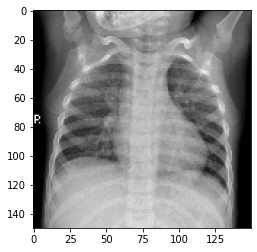

In [15]:
# view a regular image file
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

filename = train_files_normal[0] # uses first filename from glob list
img = image.load_img(filename, target_size=(150, 150))
plt.imshow(img)
plt.show()

In [16]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

(1, 150, 150, 3)


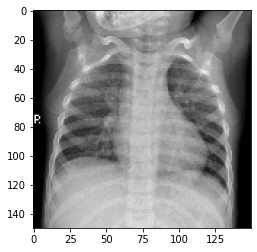

In [17]:
# view as a tensor image
import numpy as np

img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# Follow the Original Model Preprocessing
img_tensor /= 255.

# Check tensor shape
print(img_tensor.shape)

# Preview an image
plt.imshow(img_tensor[0])
plt.show()

# Step 4: Modeling

## BUILD BASELINE CNN

In [18]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime


# timer for model
original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Initialising the CNN
model = Sequential()

# Step 1 - Convolution
model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# Step 2 - Pooling
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
model.add(layers.Flatten())

# Step 4 - Full connection
model.add(layers.Dense(units = SHAPES['Batchsize'], activation = 'relu'))

model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
model.compile(optimizer = 'sgd', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(model.summary())

# Fitting the CNN to the images using fit_generator
history = model.fit_generator(training_set,
                             steps_per_epoch = 500,
                             epochs = 4,
                             validation_data = test_set,
                             validation_steps =100, verbose=1, workers=-1)
# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 100)       2800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 100)       90100     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1960100   
_________________________________________________________________
dense_2 (Dense)              (None, 1)               

None

Epoch 1/4
500/500 [==============================] - 60s 121ms/step - loss: 0.4546 - acc: 0.7895 - val_loss: 0.4575 - val_acc: 0.8365
Epoch 2/4
500/500 [==============================] - 54s 107ms/step - loss: 0.2916 - acc: 0.8752 - val_loss: 0.2798 - val_acc: 0.8530
Epoch 3/4
500/500 [==============================] - 54s 108ms/step - loss: 0.2545 - acc: 0.8944 - val_loss: 0.3583 - val_acc: 0.8477
Epoch 4/4
500/500 [==============================] - 55s 109ms/step - loss: 0.2376 - acc: 0.9017 - val_loss: 0.3649 - val_acc: 0.8520
Training took a total of 0:03:51.239226


In [19]:
results_train = model.evaluate(X_train, y_train)

4759/4759 [==============================] - 1s 125us/step


In [20]:
results_test = model.evaluate(X_test, y_test)

624/624 [==============================] - 0s 136us/step


In [21]:
# training loss and accuracy
results_train

[17.972051886021426, 0.934229850769043]

In [22]:
# test loss and accuracy
results_test

[72.10040345864418, 0.8349359035491943]

In [ ]:
# # Your code here; save the model for future reference 
# model.save('baseline_model.h5')


### Visualize accuracy and loss

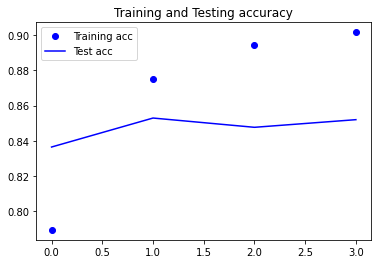

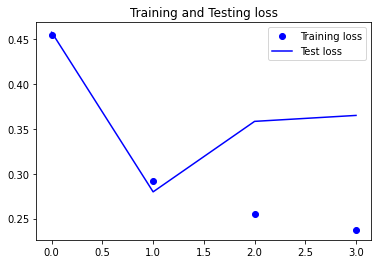

In [23]:
# view baseline cnn results evaluate
import matplotlib.pyplot as plt
%matplotlib inline 

train_acc = history.history['acc']
test_acc = history.history['val_acc']
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Testing accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Testing loss')
plt.legend()
plt.show()

### Visualize confusion matrix

              precision    recall  f1-score   support

           0       0.93      0.61      0.73       234
           1       0.80      0.97      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.85      0.83      0.83       624



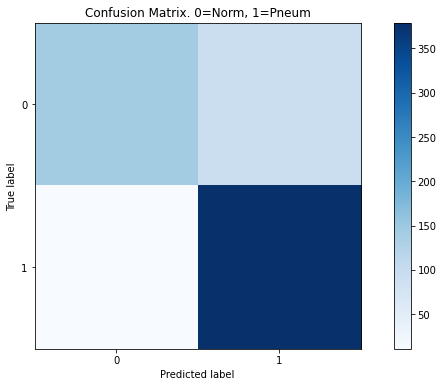

In [24]:
import sklearn.metrics as metrics
# from mod3 project
def evaluate_model(y_test, y_pred,model_history=None):
    """Takes in your target, target predictions, model history.
        Returns a metric report and confusion matrix."""
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))

    # subplot for confusion matrix
    fig, ax = plt.subplots(figsize=(12,6))
    cm = metrics.confusion_matrix(y_test,y_pred)

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix. 0=Norm, 1=Pneum')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    classes = list(range(len(cm)))  
    plt.xticks(classes, classes)
    plt.yticks(classes, classes)


    plt.show()

y_preds = model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,history)


### Interpreting Results

Model.evaluate shows my test accuracy at 84% and loss at 73%. My metrics classification report from sklearn also shows my accuracy at 84% with an excellent recall of 97% of pneumonia diagnosis. 

# Visualize Feature Map Layers

In [ ]:
from keras import models

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
model.summary()

In [ ]:
# Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [ ]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [ ]:
# visualize all channels from first activation function
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

REPEAT FOR ALL LAYERS

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

REPEAT FOR ALL MAPS OF ALL FUNCTION LAYERS

In [ ]:
# Your code here
from keras import models
import math 

# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

# Step 5: Model Hyperparams Updates

## Second model with RMSprop

In [25]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime


# timer for model
start = datetime.datetime.now()

# Initialising the CNN
rms_model = Sequential()

# Step 1 - Convolution
rms_model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# Step 2 - Pooling
rms_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
rms_model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
rms_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
rms_model.add(layers.Flatten())

# Step 4 - Full connection
rms_model.add(layers.Dense(units = SHAPES['Batchsize'], activation = 'relu'))

rms_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
rms_model.compile(optimizer = 'rmsprop', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(rms_model.summary())

# Fitting the CNN to the images using fit_generator
rms_history = rms_model.fit_generator(training_set,
                             steps_per_epoch = 500,
                             epochs = 6,
                             validation_data = test_set,
                             validation_steps =100, verbose=1, workers=-1)
# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 100)       2800      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 100)       90100     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1960100   
_________________________________________________________________
dense_4 (Dense)              (None, 1)               

None

Epoch 1/6
500/500 [==============================] - 56s 111ms/step - loss: 0.3371 - acc: 0.8692 - val_loss: 1.1986 - val_acc: 0.6266
Epoch 2/6
500/500 [==============================] - 55s 109ms/step - loss: 0.1601 - acc: 0.9396 - val_loss: 0.1494 - val_acc: 0.9237
Epoch 3/6
500/500 [==============================] - 55s 110ms/step - loss: 0.1090 - acc: 0.9589 - val_loss: 0.3512 - val_acc: 0.9024
Epoch 4/6
500/500 [==============================] - 55s 109ms/step - loss: 0.0812 - acc: 0.9691 - val_loss: 0.4857 - val_acc: 0.9167
Epoch 5/6
500/500 [==============================] - 54s 109ms/step - loss: 0.0648 - acc: 0.9758 - val_loss: 0.5678 - val_acc: 0.8981
Epoch 6/6
500/500 [==============================] - 55s 110ms/step - loss: 0.0501 - acc: 0.9820 - val_loss: 0.1822 - val_acc: 0.9157
Training took a total of 0:05:29.257752


In [26]:
results_train = rms_model.evaluate(X_train, y_train)

4759/4759 [==============================] - 1s 117us/step


In [27]:
results_test = rms_model.evaluate(X_test, y_test)

624/624 [==============================] - 0s 117us/step


In [28]:
# training loss and accuracy
results_train

[34.32647022817235, 0.9689010381698608]

In [29]:
# test loss and accuracy
results_test

[441.90555634024815, 0.8237179517745972]

HOW TO SAVE h5 model

In [ ]:
# # Your code here; save the model for future reference 
# model.save('chest_xray_downsampled_data.h5')


HOW TO LOAD A PREVIOUS SAVED h5 model

In [ ]:
# from keras.models import load_model

# model = load_model('chest_xray_all_data.h5')
# # As a reminder 
# model.summary()  

### Visualize accuracy and loss

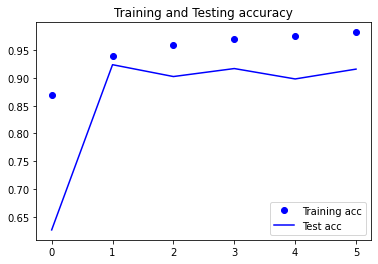

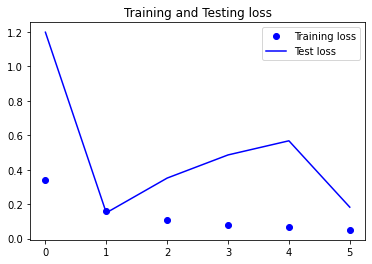

In [30]:
# view baseline cnn results evaluate
import matplotlib.pyplot as plt
%matplotlib inline 

train_acc = rms_history.history['acc']
test_acc = rms_history.history['val_acc']
train_loss = rms_history.history['loss']
test_loss = rms_history.history['val_loss']
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Testing accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Testing loss')
plt.legend()
plt.show()

### Visualize confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.55      0.70       234
           1       0.79      0.99      0.88       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



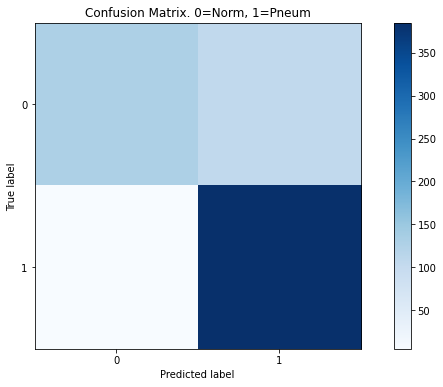

In [31]:
import sklearn.metrics as metrics
# from mod3 project
def evaluate_model(y_test, y_pred,model_history=None):
    """Takes in your target, target predictions, model history.
        Returns a metric report and confusion matrix."""
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))

    # subplot for confusion matrix
    fig, ax = plt.subplots(figsize=(12,6))
    cm = metrics.confusion_matrix(y_test,y_pred)

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix. 0=Norm, 1=Pneum')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    classes = list(range(len(cm)))  
    plt.xticks(classes, classes)
    plt.yticks(classes, classes)


    plt.show()

y_preds = rms_model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,rms_history)


### Interpreting Results

Model.evaluate shows my test accuracy at 77% and loss at 607%. Is that possible? Seems like epoch 4 was the best when looking over the graphs. My metrics classification report from sklearn also shows my accuracy at 77% with an excellent recall of 99% of pneumonia diagnosis. 

## Third model with ADAM

In [32]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime


# timer for model
start = datetime.datetime.now()

# Initialising the CNN
adam_model = Sequential()

# Step 1 - Convolution
adam_model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# Step 2 - Pooling
adam_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
adam_model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
adam_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
adam_model.add(layers.Flatten())

# Step 4 - Full connection
adam_model.add(layers.Dense(units = SHAPES['Batchsize'], activation = 'relu'))

adam_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
adam_model.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(adam_model.summary())

# Fitting the CNN to the images using fit_generator
adam_history = adam_model.fit_generator(training_set,
                             steps_per_epoch = 500,
                             epochs = 6,
                             validation_data = test_set,
                             validation_steps =100, verbose=1, workers=-1)
# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 100)       2800      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 100)       90100     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1960100   
_________________________________________________________________
dense_6 (Dense)              (None, 1)               

None

Epoch 1/6
500/500 [==============================] - 55s 110ms/step - loss: 0.2080 - acc: 0.9152 - val_loss: 0.4312 - val_acc: 0.8860
Epoch 2/6
500/500 [==============================] - 55s 109ms/step - loss: 0.1153 - acc: 0.9557 - val_loss: 0.3244 - val_acc: 0.9138
Epoch 3/6
500/500 [==============================] - 55s 109ms/step - loss: 0.0926 - acc: 0.9647 - val_loss: 0.4568 - val_acc: 0.9078
Epoch 4/6
500/500 [==============================] - 55s 110ms/step - loss: 0.0771 - acc: 0.9710 - val_loss: 0.0834 - val_acc: 0.9139
Epoch 5/6
500/500 [==============================] - 55s 109ms/step - loss: 0.0634 - acc: 0.9761 - val_loss: 0.4940 - val_acc: 0.9066
Epoch 6/6
500/500 [==============================] - 55s 109ms/step - loss: 0.0516 - acc: 0.9811 - val_loss: 0.6459 - val_acc: 0.8716
Training took a total of 0:05:28.934625


In [33]:
results_train = adam_model.evaluate(X_train, y_train)

4759/4759 [==============================] - 1s 121us/step


In [34]:
results_test = adam_model.evaluate(X_test, y_test)

624/624 [==============================] - 0s 146us/step


In [35]:
# training loss and accuracy
results_train

[17.60403391432601, 0.9682706594467163]

In [36]:
# test loss and accuracy
results_test

[178.61337060194748, 0.8621794581413269]

In [ ]:
# # Your code here; save the model for future reference 
# model.save('chest_xray_downsampled_data.h5')


### Visualize accuracy and loss

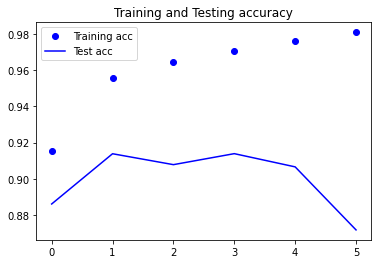

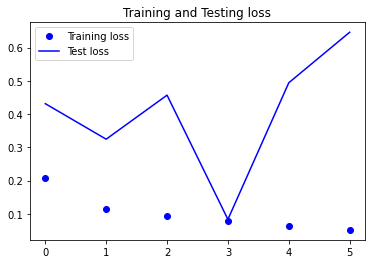

In [37]:
# view baseline cnn results evaluate
import matplotlib.pyplot as plt
%matplotlib inline 

train_acc = adam_history.history['acc']
test_acc = adam_history.history['val_acc']
train_loss = adam_history.history['loss']
test_loss = adam_history.history['val_loss']
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Testing accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Testing loss')
plt.legend()
plt.show()

### Visualize confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



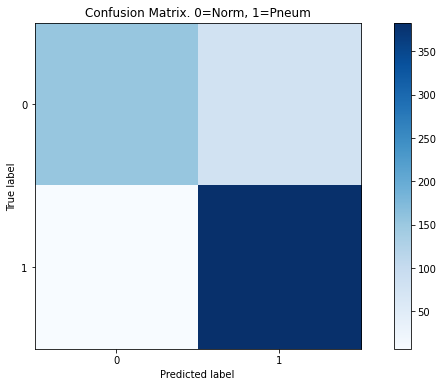

In [38]:
import sklearn.metrics as metrics
# from mod3 project
def evaluate_model(y_test, y_pred,model_history=None):
    """Takes in your target, target predictions, model history.
        Returns a metric report and confusion matrix."""
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))

    # subplot for confusion matrix
    fig, ax = plt.subplots(figsize=(12,6))
    cm = metrics.confusion_matrix(y_test,y_pred)

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix. 0=Norm, 1=Pneum')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    classes = list(range(len(cm)))  
    plt.xticks(classes, classes)
    plt.yticks(classes, classes)


    plt.show()

y_preds = adam_model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,adam_history)


### Interpreting Results

Model.evaluate shows my test accuracy at 86% and loss at 210%. Seems like epoch 4 was the best when looking over the graphs. My metrics classification report from sklearn also shows my accuracy at 86% with a good recall of 99% of pneumonia diagnosis. 

Best model so far for recall was adam and rms with 99% Why is that loss so high though? I'm going to move forward with the adam optimizer for it's generally high 99% recall and see what I can do about that loss. Better f1 score on adam. 

- baseline sgd
test accuracy at 84% and loss at 73%. sklearn also shows my accuracy at 84% with an excellent recall of 97% of pneumonia diagnosis.  
- rmsprop
test accuracy at 77% and loss at 607%. sklearn also shows my accuracy at 77% with an excellent recall of 99% of pneumonia diagnosis.  
- adam
test accuracy at 86% and loss at 210%. sklearn also shows my accuracy at 86% with a good recall of 99% of pneumonia diagnosis. 

## Fourth model with ADAM. Add Dropout. 

In [39]:
np.random.seed(111)

from keras import layers
from keras import models
from keras import optimizers
import datetime


# timer for model
start = datetime.datetime.now()

# Initialising the CNN
adam_drop_model = Sequential()

# Step 1 - Convolution
adam_drop_model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      input_shape = (SHAPES['img_width'], 
                                     SHAPES['img_height'],
                                     SHAPES['img_dim']),
                       activation = 'relu'))
# Step 2 - Pooling
adam_drop_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
adam_drop_model.add(layers.Conv2D(SHAPES['Batchsize'], (3, 3),
                      activation = 'relu'))
adam_drop_model.add(layers.MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
adam_drop_model.add(layers.Flatten())

# Step 4 - Full connection with dropout
adam_drop_model.add(layers.Dense(units = SHAPES['Batchsize'], activation = 'relu'))

# Dropout applied to the full connection layer
adam_drop_model.add(layers.Dropout(0.3))

# Step 5 - Full connection with dropout
adam_drop_model.add(layers.Dense(units = SHAPES['Batchsize'], activation = 'relu'))

# Dropout applied to the full connection layer
adam_drop_model.add(layers.Dropout(0.3))

# output
adam_drop_model.add(layers.Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
adam_drop_model.compile(optimizer = 'adam', 
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])
print()
display(adam_drop_model.summary())

# Fitting the CNN to the images using fit_generator
adam_drop_history = adam_drop_model.fit_generator(training_set,
                             steps_per_epoch = 500,
                             epochs = 6,
                             validation_data = test_set,
                             validation_steps =100, verbose=1, workers=-1)
# end timer
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))                              


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 100)       2800      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 100)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 100)       90100     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 100)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 19600)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1960100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)             

None

Epoch 1/6
500/500 [==============================] - 55s 110ms/step - loss: 0.2249 - acc: 0.9093 - val_loss: 0.2140 - val_acc: 0.8906
Epoch 2/6
500/500 [==============================] - 55s 110ms/step - loss: 0.1261 - acc: 0.9537 - val_loss: 0.1027 - val_acc: 0.9060
Epoch 3/6
500/500 [==============================] - 55s 110ms/step - loss: 0.1036 - acc: 0.9620 - val_loss: 0.6806 - val_acc: 0.8591
Epoch 4/6
500/500 [==============================] - 55s 110ms/step - loss: 0.0875 - acc: 0.9676 - val_loss: 0.5446 - val_acc: 0.9161
Epoch 5/6
500/500 [==============================] - 55s 111ms/step - loss: 0.0740 - acc: 0.9729 - val_loss: 0.2783 - val_acc: 0.9249
Epoch 6/6
500/500 [==============================] - 55s 109ms/step - loss: 0.0659 - acc: 0.9770 - val_loss: 0.5139 - val_acc: 0.9006
Training took a total of 0:05:30.617854


In [40]:
results_train = adam_drop_model.evaluate(X_train, y_train)

4759/4759 [==============================] - 1s 123us/step


In [41]:
results_test = adam_drop_model.evaluate(X_test, y_test)

624/624 [==============================] - 0s 126us/step


In [42]:
# training loss and accuracy
results_train

[10.746086222173949, 0.9691111445426941]

In [43]:
# test loss and accuracy
results_test

[133.61955882341434, 0.8605769276618958]

In [ ]:
# # Your code here; save the model for future reference 
# model.save('chest_xray_downsampled_data.h5')


### Visualize accuracy and loss

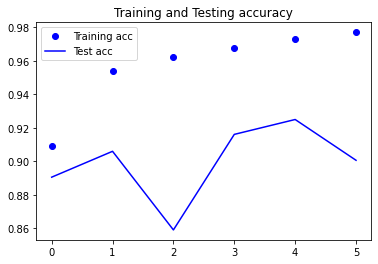

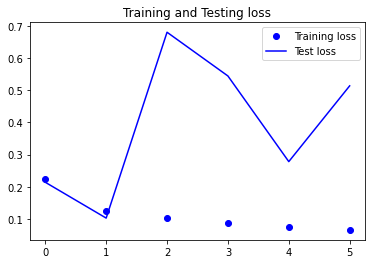

In [44]:
# view baseline cnn results evaluate
import matplotlib.pyplot as plt
%matplotlib inline 

train_acc = adam_drop_history.history['acc']
test_acc = adam_drop_history.history['val_acc']
train_loss = adam_drop_history.history['loss']
test_loss = adam_drop_history.history['val_loss']
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training acc')
plt.plot(epochs, test_acc, 'b', label='Test acc')
plt.title('Training and Testing accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Testing loss')
plt.legend()
plt.show()

### Visualize confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



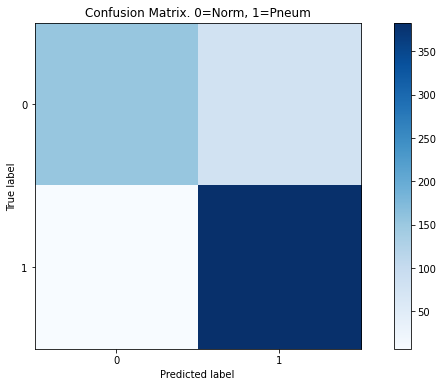

In [45]:
import sklearn.metrics as metrics
# from mod3 project
def evaluate_model(y_test, y_pred,model_history=None):
    """Takes in your target, target predictions, model history.
        Returns a metric report and confusion matrix."""
    
    ## Classification Report / Scores 
    print(metrics.classification_report(y_test,y_pred))

    # subplot for confusion matrix
    fig, ax = plt.subplots(figsize=(12,6))
    cm = metrics.confusion_matrix(y_test,y_pred)

    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix. 0=Norm, 1=Pneum')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    classes = list(range(len(cm)))  
    plt.xticks(classes, classes)
    plt.yticks(classes, classes)


    plt.show()

y_preds = adam_drop_model.predict_classes(X_test).flatten()

evaluate_model(y_test,y_preds,adam_drop_history)



### Interpreting Results

My test accuracy is 88%. Loss is 62. Recall is 94%. Better than the previous version of adam. There seems to be overfitting when comparing training acc of 95% to test at 88%. Epoch 3 had best results. 

previous models
- baseline sgd
test accuracy at 84% and loss at 73%. sklearn also shows my accuracy at 84% with an excellent recall of 97% of pneumonia diagnosis.  
- rmsprop
test accuracy at 77% and loss at 607%. sklearn also shows my accuracy at 77% with an excellent recall of 99% of pneumonia diagnosis.  
- adam
test accuracy at 86% and loss at 210%. sklearn also shows my accuracy at 86% with a good recall of 99% of pneumonia diagnosis. 

## Conclusion Summary

Based on this final model, it seems that the process was able to classify 94% of all pneumonia patients in the test set. More tuning for the future to try and get more of the patients properly classified. 